# This is the 104th solution for the Elo comepetition. 

In [1]:
#install package for NMF
#!pip install nimfa

In [2]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import collections

import gc
import warnings
warnings.filterwarnings('ignore')
import datetime
from tqdm import tqdm
np.random.seed(114514)

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import nimfa

In [3]:
def del_gc(lis):
    for i in lis:
        del i
    gc.collect()

In [4]:
#load in date
train = pd.read_csv('./input/train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('./input/test.csv', parse_dates=['first_active_month'])

target = train['target']
del train['target']

historical_transactions = pd.read_csv('./input/historical_transactions.csv', parse_dates=['purchase_date'])
new_transactions = pd.read_csv('./input/new_merchant_transactions.csv', parse_dates=['purchase_date'])

In [5]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-06-01,C_ID_92a2005557,5,2,1
1,2017-01-01,C_ID_3d0044924f,4,1,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0
3,2017-09-01,C_ID_186d6a6901,4,3,0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0


In [6]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [7]:
#Reversing the purchase amount feature back to original scale. Credit to [this amazing kernel](https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights)
historical_transactions['purchase_amount'] = np.round(historical_transactions['purchase_amount'] / 0.00150265118 + 497.06,2)
new_transactions['purchase_amount'] = np.round(new_transactions['purchase_amount'] / 0.00150265118 + 497.06,2)

## The main focus of this competition was how to extract useful imformation from categorical features.

### Applying NMF to extract purchase patterns by purchase_month and merchant_category.

In [8]:
tmp = historical_transactions[['card_id','merchant_category_id', 'month_lag', 'purchase_amount']]

#first, by purchase_month(month_lag)
tmp1 = tmp.groupby(['card_id', 'month_lag']).agg({'purchase_amount': ['count']})
tmp2 = tmp.groupby(['card_id', 'month_lag']).agg({'purchase_amount': ['mean']})
tmp3 = tmp.groupby(['card_id', 'month_lag']).agg({'purchase_amount': ['sum']})
tmp1.columns = ['purchase_count']
tmp2.columns = ['purchase_amount_mean']
tmp3.columns = ['purchase_amount_sum']

tmp1 = tmp1.unstack().fillna(0)
ids = tmp1.index
#calculate trend(correlation coefficient) of purchase_count
tmp1['purchase_count_corr'] = 0
#process 500 at a time
for i in tqdm(range(len(tmp1)//500)):
    tmp1.loc[ids[500*i:500*(i+1)], 'purchase_count_corr'] = np.corrcoef(np.arange(1, 15), tmp1.iloc[500*i:500*(i+1), :-1])[0, 1:501]
    if i==650:
        tmp1.loc[ids[500*(i+1):], 'purchase_count_corr'] = np.corrcoef(np.arange(1, 15), tmp1.iloc[500*(i+1):, :-1])[0, 1:]
        
tmp1.head()

100%|██████████| 651/651 [00:04<00:00, 132.85it/s]


purchase_count                                                 \
month_lag                  -13  -12   -11   -10    -9    -8    -7    -6    -5   
card_id                                                                         
C_ID_00007093c1            0.0  4.0  10.0  12.0  10.0  19.0  15.0  17.0   5.0   
C_ID_0001238066            0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   
C_ID_0001506ef0            2.0  5.0   8.0   0.0   1.0   3.0   2.0   2.0   2.0   
C_ID_0001793786            0.0  0.0   0.0   0.0   2.0   6.0  16.0  30.0   4.0   
C_ID_000183fdda            0.0  0.0   0.0   0.0   0.0   0.0   0.0   6.0  22.0   

                                              purchase_count_corr  
month_lag          -4    -3    -2    -1     0                      
card_id                                                            
C_ID_00007093c1  17.0   6.0  12.0  10.0  12.0            0.325133  
C_ID_0001238066  11.0  23.0  37.0  26.0  24.0            0.815934  
C_ID_0001506ef0   3.0   7.0  18.0   7.0   6.0            0.443131  
C_ID_0001793786  37.0  29.0  34.0  38.0  20.0            0.817073  
C_ID_000183fdda  25.0   9.0  26.0  28.0  28.0            0.866714

In [9]:
#repeat the same process for tmp2, tmp3

tmp2 = tmp2.unstack().fillna(0)
ids = tmp2.index
tmp2['purchase_amount_mean_corr'] = 0
for i in tqdm(range(len(tmp2)//500)):
    tmp2.loc[ids[500*i:500*(i+1)], 'purchase_amount_mean_corr'] = np.corrcoef(np.arange(1, 15), tmp2.iloc[500*i:500*(i+1), :-1])[0, 1:501]
    if i==650:
        tmp2.loc[ids[500*(i+1):], 'purchase_amount_mean_corr'] = np.corrcoef(np.arange(1, 15), tmp2.iloc[500*(i+1):, :-1])[0, 1:]
        
tmp3 = tmp3.unstack().fillna(0)
ids = tmp3.index
tmp3['purchase_amount_sum_corr'] = 0
for i in tqdm(range(len(tmp3)//500)):
    tmp3.loc[ids[500*i:500*(i+1)], 'purchase_amount_sum_corr'] = np.corrcoef(np.arange(1, 15), tmp3.iloc[500*i:500*(i+1), :-1])[0, 1:501]
    if i==650:
        tmp3.loc[ids[500*(i+1):], 'purchase_amount_sum_corr'] = np.corrcoef(np.arange(1, 15), tmp3.iloc[500*(i+1):, :-1])[0, 1:]

100%|██████████| 651/651 [00:04<00:00, 147.34it/s]


In [10]:
#apply NMF
nmf = nimfa.Nmf(tmp1.drop('purchase_count_corr', axis=1).values, seed='nndsvd', max_iter=200, rank=5, update='euclidean', objective='fro')
nmf_fit = nmf()
nmf_feats_month_lag_count = nmf_fit.basis()
nmf_feats_month_lag_count = pd.DataFrame(nmf_feats_month_lag_count)
nmf_feats_month_lag_count.columns = ['nmf_feats_month_lag_count_'+str(i) for i in range(1, 6)]
nmf_feats_month_lag_count['purchase_count_corr'] = tmp1['purchase_count_corr'].values

nmf = nimfa.Nmf(tmp2.drop('purchase_amount_mean_corr', axis=1).values, seed='nndsvd', max_iter=200, rank=5, update='euclidean', objective='fro')
nmf_fit = nmf()
nmf_feats_month_lag_amount_mean = nmf_fit.basis()
nmf_feats_month_lag_amount_mean = pd.DataFrame(nmf_feats_month_lag_amount_mean)
nmf_feats_month_lag_amount_mean.columns = ['nmf_feats_month_lag_amount_mean_'+str(i) for i in range(1, 6)]
nmf_feats_month_lag_amount_mean['purchase_amount_mean_corr']  =tmp2['purchase_amount_mean_corr'].values

nmf = nimfa.Nmf(tmp3.drop('purchase_amount_sum_corr', axis=1).values, seed='nndsvd', max_iter=200, rank=5, update='euclidean', objective='fro')
nmf_fit = nmf()
nmf_feats_month_lag_amount_sum = nmf_fit.basis()
nmf_feats_month_lag_amount_sum = pd.DataFrame(nmf_feats_month_lag_amount_sum)
nmf_feats_month_lag_amount_sum.columns = ['nmf_feats_month_lag_amount_sum_'+str(i) for i in range(1, 6)]
nmf_feats_month_lag_amount_sum['purchase_amount_sum_corr']  =tmp3['purchase_amount_sum_corr'].values

In [11]:
#repeat the same process, but this time about merchant_category
tmp1 = tmp.groupby(['card_id', 'merchant_category_id']).agg({'purchase_amount': ['count']})
tmp2 = tmp.groupby(['card_id', 'merchant_category_id']).agg({'purchase_amount': ['mean']})
tmp3 = tmp.groupby(['card_id', 'merchant_category_id']).agg({'purchase_amount': ['sum']})
tmp1.columns = ['purchase_count']
tmp2.columns = ['purchase_amount_mean']
tmp3.columns = ['purchase_amount_sum']

tmp1 = tmp1.unstack().fillna(0)
tmp2 = tmp2.unstack().fillna(0)
tmp3 = tmp3.unstack().fillna(0)

nmf = nimfa.Nmf(tmp1.values, seed='nndsvd', max_iter=200, rank=10, update='euclidean', objective='fro')
nmf_fit = nmf()
nmf_feats_merch_cate_count = nmf_fit.basis()
nmf_feats_merch_cate_count = pd.DataFrame(nmf_feats_merch_cate_count)
nmf_feats_merch_cate_count.columns = ['nmf_feats_merch_cate_count_'+str(i) for i in range(1, 11)]

nmf = nimfa.Nmf(tmp2.values, seed='nndsvd', max_iter=200, rank=10, update='euclidean', objective='fro')
nmf_fit = nmf()
nmf_feats_merch_cate_amount_mean = nmf_fit.basis()
nmf_feats_merch_cate_amount_mean = pd.DataFrame(nmf_feats_merch_cate_amount_mean)
nmf_feats_merch_cate_amount_mean.columns = ['nmf_feats_merch_cate_amount_mean_'+str(i) for i in range(1, 11)]

nmf = nimfa.Nmf(tmp3.values, seed='nndsvd', max_iter=200, rank=10, update='euclidean', objective='fro')
nmf_fit = nmf()
nmf_feats_merch_cate_amount_sum = nmf_fit.basis()
nmf_feats_merch_cate_amount_sum = pd.DataFrame(nmf_feats_merch_cate_amount_sum)
nmf_feats_merch_cate_amount_sum.columns = ['nmf_feats_merch_cate_amount_sum_'+str(i) for i in range(1, 11)]

In [12]:
#merging to train/test
nmf_feats_df = [nmf_feats_month_lag_count, nmf_feats_month_lag_amount_mean,nmf_feats_month_lag_amount_sum, nmf_feats_merch_cate_count, nmf_feats_merch_cate_amount_mean, nmf_feats_merch_cate_amount_sum]

for df in nmf_feats_df:
    df['card_id'] = tmp1.index
    train = train.merge(df, on='card_id', how='left')
    test = test.merge(df, on='card_id', how='left')

In [13]:
del_gc(nmf_feats_df)

### Because there are too many merchant_ids, rather than expanding it to one-hot represententions which causes memory problrms, I calculated entropy for merchant_id. This value will get smaller as a card_id makes repeated purchases at the same merchants.

In [14]:
grp = historical_transactions.groupby('card_id')

#normalize by the purchase_counts(which was better than normalizing by number of unique merchants)
def norm_entropy(vec):
    entropys = list()
    count = collections.Counter(vec)
    countall = float(np.sum(np.array(list(count.values()))))
    for item in count.items():
        counteach = item[1]
        prob = counteach / countall
        entropyeach = -prob * np.log(prob)
        norm_entropy = entropyeach / len(vec)
        entropys.append(norm_entropy)
    entropy = np.sum(entropys)
    return entropy

entropy_list = []
for grp_name, grp_idx in grp.groups.items():
    tmp = historical_transactions.loc[grp_idx, 'merchant_id']
    e = norm_entropy(tmp)
    entropy_list.append(e)
    
entropy_df = pd.DataFrame()
entropy_df['card_id'] = [i for i in grp.groups]
entropy_df['merchant_id_entropy'] = entropy_list

entropy_df.head()

,card_id,merchant_id_entropy
0,C_ID_00007093c1,0.017502
1,C_ID_0001238066,0.028889
2,C_ID_0001506ef0,0.043371
3,C_ID_0001793786,0.020444
4,C_ID_000183fdda,0.027546


### Also, calculate the ratio of merchants that a card_id made purchases only once.

In [15]:
def only_once_ratio(vec):
    count = collections.Counter(vec)
    arr = np.array(list(count.values()))
    countall = len(arr)
    only_once = len(arr[arr==1])
    only_once_ratio = only_once / countall
    return only_once_ratio

ratio_list = []
for grp_name, grp_idx in grp.groups.items():
    tmp = historical_transactions.loc[grp_idx, 'merchant_id']
    r = only_once_ratio(tmp)
    ratio_list.append(r)
    
only_once_ratio_df = pd.DataFrame()
only_once_ratio_df['card_id'] = [i for i in grp.groups]
only_once_ratio_df['only_once_merchant_ratio'] = ratio_list

only_once_ratio_df.head()

,card_id,only_once_merchant_ratio
0,C_ID_00007093c1,0.379310
1,C_ID_0001238066,0.800000
2,C_ID_0001506ef0,0.642857
3,C_ID_0001793786,0.697479
4,C_ID_000183fdda,0.602740


### Inputing missing values here.

In [16]:
for df in [historical_transactions, new_transactions]:
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)
    df['category_2'].fillna(1.0, inplace=True)

### Calculate the gaps between purchase_dates for each card_id. Aggregate later.

In [17]:
time_delta_df = historical_transactions.sort_values(['card_id', 'purchase_date'])[['card_id', 'purchase_date']].reset_index(drop=True)
time_delta_df['time_since_last_purchase'] = 0

before_id = None
zero_points = []
for i, id_ in tqdm(time_delta_df["card_id"].iteritems()):
    if id_ != before_id:
        zero_points.append(i)
        before_id = id_

time_delta_df.loc[:,"time_since_last_purchase"] = time_delta_df.loc[:,"purchase_date"].diff()
time_delta_df.loc[zero_points,"time_since_last_purchase"] = pd.Timedelta(0)

time_delta_df['time_since_last_purchase'] = time_delta_df['time_since_last_purchase'].astype(int) * 10**(-9)
time_delta_df = time_delta_df.groupby('card_id').agg({'time_since_last_purchase':['mean', 'var', 'max']})
time_delta_df.columns = ['_'.join(col) for col in time_delta_df.columns.values]
time_delta_df.head()

29112361it [00:11, 2446995.72it/s]


,time_since_last_purchase_mean,time_since_last_purchase_var,time_since_last_purchase_max
card_id,,,
C_ID_00007093c1,218977.543624,1.645098e+11,2858776.0
C_ID_0001238066,106592.073171,1.879078e+10,751587.0
C_ID_0001506ef0,522125.378788,6.717544e+11,4320078.0
C_ID_0001793786,113368.041667,7.252982e+10,2222144.0
C_ID_000183fdda,121478.291667,4.028048e+10,1227346.0


### Extract some other time-related features and also some preprocessing.

In [18]:
for df in [historical_transactions, new_transactions]:
    #time related feature from purchase date
    df['purchase_year'] = df['purchase_date'].dt.year
    df['purchase_weekofyear'] = df['purchase_date'].dt.weekofyear
    df['purchase_month'] = df['purchase_date'].dt.month
    df['purchase_dayofweek'] = df['purchase_date'].dt.dayofweek
    df['purchase_weekend'] = (df['purchase_dayofweek'] >=5).astype(int)
    df['purchase_hour'] = df['purchase_date'].dt.hour
   
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    
    df['month_diff'] = ((datetime.datetime(2018, 12, 27) - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    
#one-hot encode month_lag
historical_transactions = pd.get_dummies(historical_transactions, columns=['month_lag'])
new_transactions = pd.get_dummies(new_transactions, columns=['month_lag'])

In [19]:
#converting purchase_date into int
for df in [historical_transactions, new_transactions]:
    df.loc[:, 'purchase_date_int'] = pd.DatetimeIndex(df['purchase_date']).astype(np.int64) * 1e-9

### Aggregate numerical features. 

In [20]:
def aggregate_hist_transactions(df):
    
    #df.loc[:, 'purchase_date'] = pd.DatetimeIndex(df['purchase_date']).astype(np.int64) * 1e-9
    
    aggs = {
        'card_id': ['size'], #transaction_count
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'],
        'installments': ['sum', 'max', 'min', 'mean', 'var'],
        'purchase_year': ['nunique'],
        'purchase_month': ['nunique'],
        'purchase_hour': ['nunique'],
        'purchase_weekofyear': ['nunique'],
        'purchase_dayofweek': ['nunique'],
        'purchase_date': ['min', 'max'],
        'purchase_date_int':['var'],
        'purchase_weekend': ['sum', 'mean'],
        'month_diff': ['mean', 'var'],
        'month_lag_-13': ['mean','sum'], 
        'month_lag_-12': ['mean','sum'], 
        'month_lag_-11': ['mean','sum'], 
        'month_lag_-10': ['mean','sum'], 
        'month_lag_-9': ['mean','sum'], 
        'month_lag_-8': ['mean','sum'], 
        'month_lag_-7': ['mean','sum'], 
        'month_lag_-6': ['mean','sum'], 
        'month_lag_-5': ['mean','sum'], 
        'month_lag_-4': ['mean','sum'], 
        'month_lag_-3': ['mean','sum'], 
        'month_lag_-2': ['mean','sum'], 
        'month_lag_-1': ['mean','sum'], 
        'month_lag_0': ['mean','sum']
        }
    
    for col in ['category_2','category_3']:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        aggs[col+'_mean'] = ['mean']
        
    
    agg_df = df.groupby(['card_id']).agg(aggs)
    agg_df.columns = ['_'.join(col) for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    return agg_df

In [21]:
def aggregate_new_transactions(df):
    
    #df.loc[:, 'purchase_date'] = pd.DatetimeIndex(df['purchase_date']).astype(np.int64) * 1e-9
    
    aggs = {
        'card_id': ['size'], #transaction_count
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'],
        'installments': ['sum', 'max', 'min', 'mean', 'var'],
        'purchase_year': ['nunique'],
        'purchase_month': ['nunique'],
        'purchase_hour': ['nunique'],
        'purchase_weekofyear': ['nunique'],
        'purchase_dayofweek': ['nunique'],
        'purchase_date': ['min', 'max'],
        'purchase_date_int':['var'],
        'purchase_weekend': ['sum', 'mean'],
        'month_diff': ['mean', 'var'],
        'month_lag_2': ['mean','sum'], 
        'month_lag_1': ['mean','sum']
        }
    
    for col in ['category_2','category_3']:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        aggs[col+'_mean'] = ['mean']
        
    
    agg_df = df.groupby(['card_id']).agg(aggs)
    agg_df.columns = ['_'.join(col) for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    return agg_df

In [22]:
historical = aggregate_hist_transactions(historical_transactions)
historical.columns = ['hist_' + c if c != 'card_id' else c for c in historical.columns]
historical.head()

,card_id,hist_card_id_size,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_merchant_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_installments_sum,hist_installments_max,hist_installments_min,hist_installments_mean,hist_installments_var,hist_purchase_year_nunique,hist_purchase_month_nunique,hist_purchase_hour_nunique,hist_purchase_weekofyear_nunique,hist_purchase_dayofweek_nunique,hist_purchase_date_min,hist_purchase_date_max,...,hist_month_lag_-11_sum,hist_month_lag_-10_mean,hist_month_lag_-10_sum,hist_month_lag_-9_mean,hist_month_lag_-9_sum,hist_month_lag_-8_mean,hist_month_lag_-8_sum,hist_month_lag_-7_mean,hist_month_lag_-7_sum,hist_month_lag_-6_mean,hist_month_lag_-6_sum,hist_month_lag_-5_mean,hist_month_lag_-5_sum,hist_month_lag_-4_mean,hist_month_lag_-4_sum,hist_month_lag_-3_mean,hist_month_lag_-3_sum,hist_month_lag_-2_mean,hist_month_lag_-2_sum,hist_month_lag_-1_mean,hist_month_lag_-1_sum,hist_month_lag_0_mean,hist_month_lag_0_sum,hist_category_2_mean_mean,hist_category_3_mean_mean
0,C_ID_00007093c1,149,114,0.765101,28,0.187919,29,13,22922.30,1500.00,12.00,153.840940,39366.639148,192,6,1,1.288591,0.585072,2,12,18,39,7,2017-02-14 14:00:43,2018-02-27 05:14:57,...,10,0.080537,12,0.067114,10.0,0.127517,19.0,0.100671,15.0,0.114094,17.0,0.033557,5.0,0.114094,17.0,0.040268,6.0,0.080537,12.0,0.067114,10.0,0.080537,12.0,602.593747,282.562269
1,C_ID_0001238066,123,120,0.975610,2,0.016260,65,17,12925.46,1008.22,8.00,105.085041,16027.499309,198,10,-1,1.609756,2.207117,2,6,20,23,7,2017-09-28 22:25:14,2018-02-27 16:18:59,...,0,0.000000,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.016260,2.0,0.089431,11.0,0.186992,23.0,0.300813,37.0,0.211382,26.0,0.195122,24.0,527.311999,328.616051
2,C_ID_0001506ef0,66,62,0.939394,0,0.000000,28,12,9778.74,1491.00,4.27,148.162727,98784.967756,1,1,0,0.015152,0.015152,2,11,15,24,7,2017-01-14 16:16:01,2018-02-17 12:33:56,...,8,0.000000,0,0.015152,1.0,0.045455,3.0,0.030303,2.0,0.030303,2.0,0.030303,2.0,0.045455,3.0,0.106061,7.0,0.272727,18.0,0.106061,7.0,0.090909,6.0,614.964290,727.916691
3,C_ID_0001793786,216,189,0.875000,2,0.009259,119,24,82884.22,3527.80,1.00,383.723241,309559.393304,5,1,0,0.023148,0.022717,1,10,21,33,7,2017-01-21 10:15:21,2017-10-31 20:20:18,...,0,0.000000,0,0.009259,2.0,0.027778,6.0,0.074074,16.0,0.138889,30.0,0.018519,4.0,0.171296,37.0,0.134259,29.0,0.157407,34.0,0.175926,38.0,0.092593,20.0,495.316658,723.856172
4,C_ID_000183fdda,144,137,0.951389,4,0.027778,73,21,25765.65,2337.00,6.00,178.928125,122043.717880,264,10,-1,1.833333,4.489510,2,7,19,27,7,2017-08-07 09:49:14,2018-02-25 20:57:08,...,0,0.000000,0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.041667,6.0,0.152778,22.0,0.173611,25.0,0.062500,9.0,0.180556,26.0,0.194444,28.0,0.194444,28.0,608.803540,329.242685


In [23]:
new = aggregate_new_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new.head()

,card_id,new_card_id_size,new_authorized_flag_sum,new_authorized_flag_mean,new_category_1_sum,new_category_1_mean,new_merchant_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_mean,new_purchase_amount_var,new_installments_sum,new_installments_max,new_installments_min,new_installments_mean,new_installments_var,new_purchase_year_nunique,new_purchase_month_nunique,new_purchase_hour_nunique,new_purchase_weekofyear_nunique,new_purchase_dayofweek_nunique,new_purchase_date_min,new_purchase_date_max,new_purchase_date_int_var,new_purchase_weekend_sum,new_purchase_weekend_mean,new_month_diff_mean,new_month_diff_var,new_month_lag_2_mean,new_month_lag_2_sum,new_month_lag_1_mean,new_month_lag_1_sum,new_category_2_mean_mean,new_category_3_mean_mean
0,C_ID_00007093c1,2,2,1,0,0.000000,2,2,110.00,60.00,50.00,55.000000,50.000000,2,1,1,1.000000,0.000000,1,1,2,2,2,2018-04-03 11:13:35,2018-04-09 16:23:59,1.441974e+11,0,0.000000,10.000000,0.000000,1.000000,2,0.000000,0,130.703562,93.449287
1,C_ID_0001238066,26,26,1,2,0.076923,25,9,3040.99,444.94,4.00,116.961154,13321.705107,42,10,-1,1.615385,4.326154,1,2,16,9,6,2018-03-01 16:48:27,2018-04-30 19:57:30,2.335272e+12,12,0.461538,10.038462,0.038462,0.346154,9,0.653846,17,131.021676,159.749274
2,C_ID_0001506ef0,2,2,1,0,0.000000,2,2,30.92,21.00,9.92,15.460000,61.383200,0,0,0,0.000000,0.000000,1,1,2,2,2,2018-03-16 22:21:58,2018-03-22 09:14:30,1.109921e+11,0,0.000000,10.000000,0.000000,0.000000,0,1.000000,2,130.473380,102.428840
3,C_ID_0001793786,31,31,1,0,0.000000,31,14,15256.05,2580.00,6.00,492.130645,397363.952280,0,0,0,0.000000,0.000000,1,2,10,6,6,2017-11-15 15:44:20,2017-12-31 17:35:56,1.838299e+12,14,0.451613,14.000000,0.000000,0.322581,10,0.677419,21,129.942968,102.428840
4,C_ID_000183fdda,11,11,1,0,0.000000,11,6,1081.56,425.40,9.70,98.323636,14811.537265,16,4,-1,1.454545,1.672727,1,2,8,7,6,2018-03-02 12:26:26,2018-04-30 14:59:53,3.533515e+12,2,0.181818,10.000000,0.000000,0.272727,3,0.727273,8,130.473380,250.158348


In [24]:
#some more features using aggregated features

historical['hist_purchase_date_diff'] = (historical['hist_purchase_date_max'] - historical['hist_purchase_date_min']).dt.days
historical['hist_purchase_date_average'] = historical['hist_purchase_date_diff'] / historical['hist_card_id_size']
historical['hist_purchase_date_uptonow'] = (datetime.datetime(2018, 12, 27) - historical['hist_purchase_date_max']).dt.days

new['new_purchase_date_diff'] = (new['new_purchase_date_max'] - new['new_purchase_date_min']).dt.days
new['new_purchase_date_average'] = new['new_purchase_date_diff'] / new['new_card_id_size']
new['new_purchase_date_uptonow'] = (datetime.datetime(2018, 12, 27) - new['new_purchase_date_max']).dt.days

In [25]:
#merge into train/test

train = pd.merge(train, historical, on='card_id', how='left')
test = pd.merge(test, historical, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, time_delta_df, on='card_id', how='left')
test = pd.merge(test, time_delta_df, on='card_id', how='left')

train = pd.merge(train, entropy_df, on='card_id', how='left')
test = pd.merge(test, entropy_df, on='card_id', how='left')

train = pd.merge(train, only_once_ratio_df, on='card_id', how='left')
test = pd.merge(test, only_once_ratio_df, on='card_id', how='left')

### Add some features in train/test

In [26]:
for df in [train, test]:
    #df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['first_dayofweek'] = df['first_active_month'].dt.dayofweek
    df['first_weekofyear'] = df['first_active_month'].dt.weekofyear
    df['first_month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max', 'hist_purchase_date_min', 'new_purchase_date_max', 'new_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_card_id_size'] + df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_purchase_amount_sum'] + df['hist_purchase_amount_sum']

### Add sum of purchase counts per category in histrical transactions

In [27]:
merch_category_sum = pd.read_csv('merch_category_sum.csv')

train = pd.merge(train, merch_category_sum, on='card_id', how='left')
test = pd.merge(test, merch_category_sum, on='card_id', how='left')

In [28]:
#save memory
del merch_category_sum, historical, new, time_delta_df, entropy_df, only_once_ratio_df
gc.collect()

77

### New features as a ratio of 'new_hoge' over 'hist_hoge'

In [29]:
for col in tqdm(train.columns.values):
    if 'hist_' in col:
        #remove 'hist_'
        col_base = col.replace('hist_', '')
        try:
            new_col = 'new_' + col_base
            train[new_col+'_over_'+col] = train[new_col] / train[col]
            test[new_col+'_over_'+col] = test[new_col] / test[col]
        except:
            pass

100%|██████████| 266/266 [00:02<00:00, 107.72it/s]


In [30]:
tmp = new_transactions[['card_id', 'merchant_category_id']]
tmp = tmp[(tmp['merchant_category_id'] == 755) | (tmp['merchant_category_id'] == 511) | (tmp['merchant_category_id'] == 451)]
tmp.reset_index(inplace=True, drop=True)
tmp = pd.get_dummies(tmp, columns=['merchant_category_id'])
tmp = tmp.groupby('card_id').sum()
tmp.columns = ['new_'+col for col in tmp.columns]
tmp.reset_index(inplace=True)

train = train.merge(tmp, on='card_id', how='left')
test = test.merge(tmp, on='card_id', how='left')

train['merchant_category_755_ratio'] = train['merchant_category_id_755'] / train['new_merchant_category_id_755']
train['merchant_category_451_ratio'] = train['merchant_category_id_451'] / train['new_merchant_category_id_451']
train['merchant_category_511_ratio'] = train['merchant_category_id_511'] / train['new_merchant_category_id_511']

test['merchant_category_755_ratio'] = test['merchant_category_id_755'] / test['new_merchant_category_id_755']
test['merchant_category_451_ratio'] = test['merchant_category_id_451'] / test['new_merchant_category_id_451']
test['merchant_category_511_ratio'] = test['merchant_category_id_511'] / test['new_merchant_category_id_511']

### New features as a ratio of date-related features to 'hist_month_diff_mean'

In [31]:
cols = train.columns

for col in cols:
    if 'date' in col:
        train[col+"_over_hist_month_diff_mean"] = train[col] / train['hist_month_diff_mean']
        test[col+"_over_hist_month_diff_mean"] = test[col] / test['hist_month_diff_mean']

### More ratio features using new_purchase_amount features

In [32]:
purch_amount_feats = ['new_purchase_amount_sum', 'new_purchase_amount_max',
                                         'new_purchase_amount_min', 'new_purchase_amount_mean', 'new_purchase_amount_var']

for df in [train, test]:
    for f1 in purch_amount_feats:
        for f2 in purch_amount_feats:
            df[f1+'_over_'+f2] = df[f1] / df[f2]
            
for i in purch_amount_feats:
    del train[i+'_over_'+i], test[i+'_over_'+i]

In [33]:
train.shape, test.shape

((201917, 345), (123623, 345))

In [34]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,nmf_feats_month_lag_count_1,nmf_feats_month_lag_count_2,nmf_feats_month_lag_count_3,nmf_feats_month_lag_count_4,nmf_feats_month_lag_count_5,purchase_count_corr,nmf_feats_month_lag_amount_mean_1,nmf_feats_month_lag_amount_mean_2,nmf_feats_month_lag_amount_mean_3,nmf_feats_month_lag_amount_mean_4,nmf_feats_month_lag_amount_mean_5,purchase_amount_mean_corr,nmf_feats_month_lag_amount_sum_1,nmf_feats_month_lag_amount_sum_2,nmf_feats_month_lag_amount_sum_3,nmf_feats_month_lag_amount_sum_4,nmf_feats_month_lag_amount_sum_5,purchase_amount_sum_corr,nmf_feats_merch_cate_count_1,nmf_feats_merch_cate_count_2,...,new_purchase_date_max_over_hist_purchase_date_max_over_hist_month_diff_mean,new_purchase_date_int_var_over_hist_purchase_date_int_var_over_hist_month_diff_mean,new_purchase_date_diff_over_hist_purchase_date_diff_over_hist_month_diff_mean,new_purchase_date_average_over_hist_purchase_date_average_over_hist_month_diff_mean,new_purchase_date_uptonow_over_hist_purchase_date_uptonow_over_hist_month_diff_mean,new_purchase_amount_sum_over_new_purchase_amount_max,new_purchase_amount_sum_over_new_purchase_amount_min,new_purchase_amount_sum_over_new_purchase_amount_mean,new_purchase_amount_sum_over_new_purchase_amount_var,new_purchase_amount_max_over_new_purchase_amount_sum,new_purchase_amount_max_over_new_purchase_amount_min,new_purchase_amount_max_over_new_purchase_amount_mean,new_purchase_amount_max_over_new_purchase_amount_var,new_purchase_amount_min_over_new_purchase_amount_sum,new_purchase_amount_min_over_new_purchase_amount_max,new_purchase_amount_min_over_new_purchase_amount_mean,new_purchase_amount_min_over_new_purchase_amount_var,new_purchase_amount_mean_over_new_purchase_amount_sum,new_purchase_amount_mean_over_new_purchase_amount_max,new_purchase_amount_mean_over_new_purchase_amount_min,new_purchase_amount_mean_over_new_purchase_amount_var,new_purchase_amount_var_over_new_purchase_amount_sum,new_purchase_amount_var_over_new_purchase_amount_max,new_purchase_amount_var_over_new_purchase_amount_min,new_purchase_amount_var_over_new_purchase_amount_mean
0,2017-06-01,C_ID_92a2005557,5,2,1,6.586336e-01,1.110661e-01,2.220446e-16,2.220446e-16,5.216330e-01,0.627174,1.537899e-03,1.252456e-06,0.027680,0.009995,0.016309,0.785119,2.282817e-02,0.577245,0.105277,0.000115,0.200952,0.531769,0.064751,2.381065e-01,...,0.099631,0.004952,0.022152,0.250416,0.078701,8.728300,174.566000,23.0,0.320549,0.114570,20.000000,2.635106,0.036725,0.005728,0.050000,0.131755,0.001836,0.043478,0.379491,7.589826,0.013937,3.119652,27.229255,544.585104,71.751987
1,2017-01-01,C_ID_3d0044924f,4,1,0,5.595394e-01,4.348084e-01,3.990877e-01,2.456725e-14,2.220446e-16,0.625941,1.838026e-03,2.011846e-02,0.010877,0.010883,0.011560,-0.308561,3.377920e-02,0.063921,0.166858,0.158901,0.159614,-0.053629,0.080666,6.820162e-02,...,0.090454,0.004550,0.012946,0.755184,0.074265,2.790527,16.765531,6.0,0.920410,0.358355,6.008016,2.150131,0.329834,0.059646,0.166444,0.357877,0.054899,0.166667,0.465088,2.794255,0.153402,1.086472,3.031830,18.215284,6.518833
2,2016-08-01,C_ID_d639edf6cd,2,2,0,1.764863e-09,1.131287e-01,1.786838e-02,2.768507e-02,2.220446e-16,-0.666971,4.700995e-11,7.007066e-03,0.005022,0.006508,0.052776,0.367661,2.201731e-09,0.001848,0.032416,0.012277,0.005497,-0.140996,0.229362,2.220446e-16,...,0.099646,NaN,0.000000,0.000000,0.079577,1.000000,1.000000,1.0,NaN,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
3,2017-09-01,C_ID_186d6a6901,4,3,0,3.118988e-01,2.220446e-16,2.392129e-14,2.793595e-10,2.220446e-16,0.582040,7.118273e-03,4.941790e-07,0.011649,0.000059,0.018164,0.492867,3.522057e-02,0.025622,0.033597,0.000079,0.004914,0.580529,0.007681,1.337748e-01,...,0.100148,0.008050,0.026589,0.292477,0.083612,3.185822,44.938824,7.0,0.198713,0.313891,14.105882,2.197235,0.062374,0.022252,0.070892,0.155767,0.004422,0.142857,0.455117,6.419832,0.028388,5.032383,16.032273,226.14

### Modeling & Prediction by LightGBM
I used 30 diferrent random seeds for the final submission but here I only show the modeling with the fixed seed.

In [35]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_features = [c for c in features if 'feature_' in c]

In [36]:
train['outliers'] = 0
train.loc[target < -30, 'outliers'] = 1

oof_total = np.zeros(len(train))
predictions_total = np.zeros(len(test))
total_importance_df = pd.DataFrame()

#####change to 30 when seed avaraging#####
for seed in range(1):
    print('Starting {}th iteration'.format(seed))
    
    param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         'min_child_samples': 20,
         'boosting': 'gbdt',
         'feature_fraction': 0.9,
         'bagging_freq': 1,
         'bagging_fraction': 0.9 ,
         'bagging_seed': 11,
         'metric': 'rmse',
         'lambda_l1': 0.1,
         'verbosity': -1,
         'nthread': 4,
         'random_state': seed}

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=114514)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold, (train_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):
        print('fold {}'.format(fold))
        train_data = lgb.Dataset(train.iloc[train_idx][features], label=target.iloc[train_idx], categorical_feature=categorical_features)
        val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_features)
        num_round = 10000
        clf = lgb.train(param, train_data, num_round, valid_sets = [train_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(train[features].values[val_idx], num_iteration=clf.best_iteration)
    
        fold_importance_df = pd.DataFrame()
        fold_importance_df['Feature'] = features
        fold_importance_df['importance'] = clf.feature_importance(importance_type='gain')
        #fold_importance_df['fold'] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

    #####change to 30 when seed avaraging#####    
    oof_total += oof / 1
    predictions_total += predictions / 1
    
    #CV score with this seed
    print('5fold CV score: {}'.format(np.sqrt(mean_squared_error(oof, target))))
    
    feature_importance_df = feature_importance_df.groupby('Feature')['importance'].mean().reset_index()
    total_importance_df = pd.concat([total_importance_df, feature_importance_df], axis=0)
    
#CV score for seed averaged prediction
print('100 models avg 5fold CV score: {}'.format(np.sqrt(mean_squared_error(oof_total, target))))
total_importance_df = total_importance_df.groupby('Feature')['importance'].mean().reset_index()

Starting 0th iteration
fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.64014	valid_1's rmse: 3.70654
[200]	training's rmse: 3.54413	valid_1's rmse: 3.67245
[300]	training's rmse: 3.48441	valid_1's rmse: 3.65829
[400]	training's rmse: 3.44258	valid_1's rmse: 3.65164
[500]	training's rmse: 3.40683	valid_1's rmse: 3.64834
[600]	training's rmse: 3.37715	valid_1's rmse: 3.64673
[700]	training's rmse: 3.35115	valid_1's rmse: 3.64581
[800]	training's rmse: 3.32659	valid_1's rmse: 3.64552
[900]	training's rmse: 3.30512	valid_1's rmse: 3.64483
[1000]	training's rmse: 3.28384	valid_1's rmse: 3.64439
[1100]	training's rmse: 3.2631	valid_1's rmse: 3.64412
[1200]	training's rmse: 3.2437	valid_1's rmse: 3.64425
Early stopping, best iteration is:
[1118]	training's rmse: 3.25899	valid_1's rmse: 3.64386
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.64264	valid_1's rmse: 3.7096
[200]	training's rmse: 3.54958	

Text(0.5, 1.0, 'LightGBM top50 Feature Importances (avg over folds)')

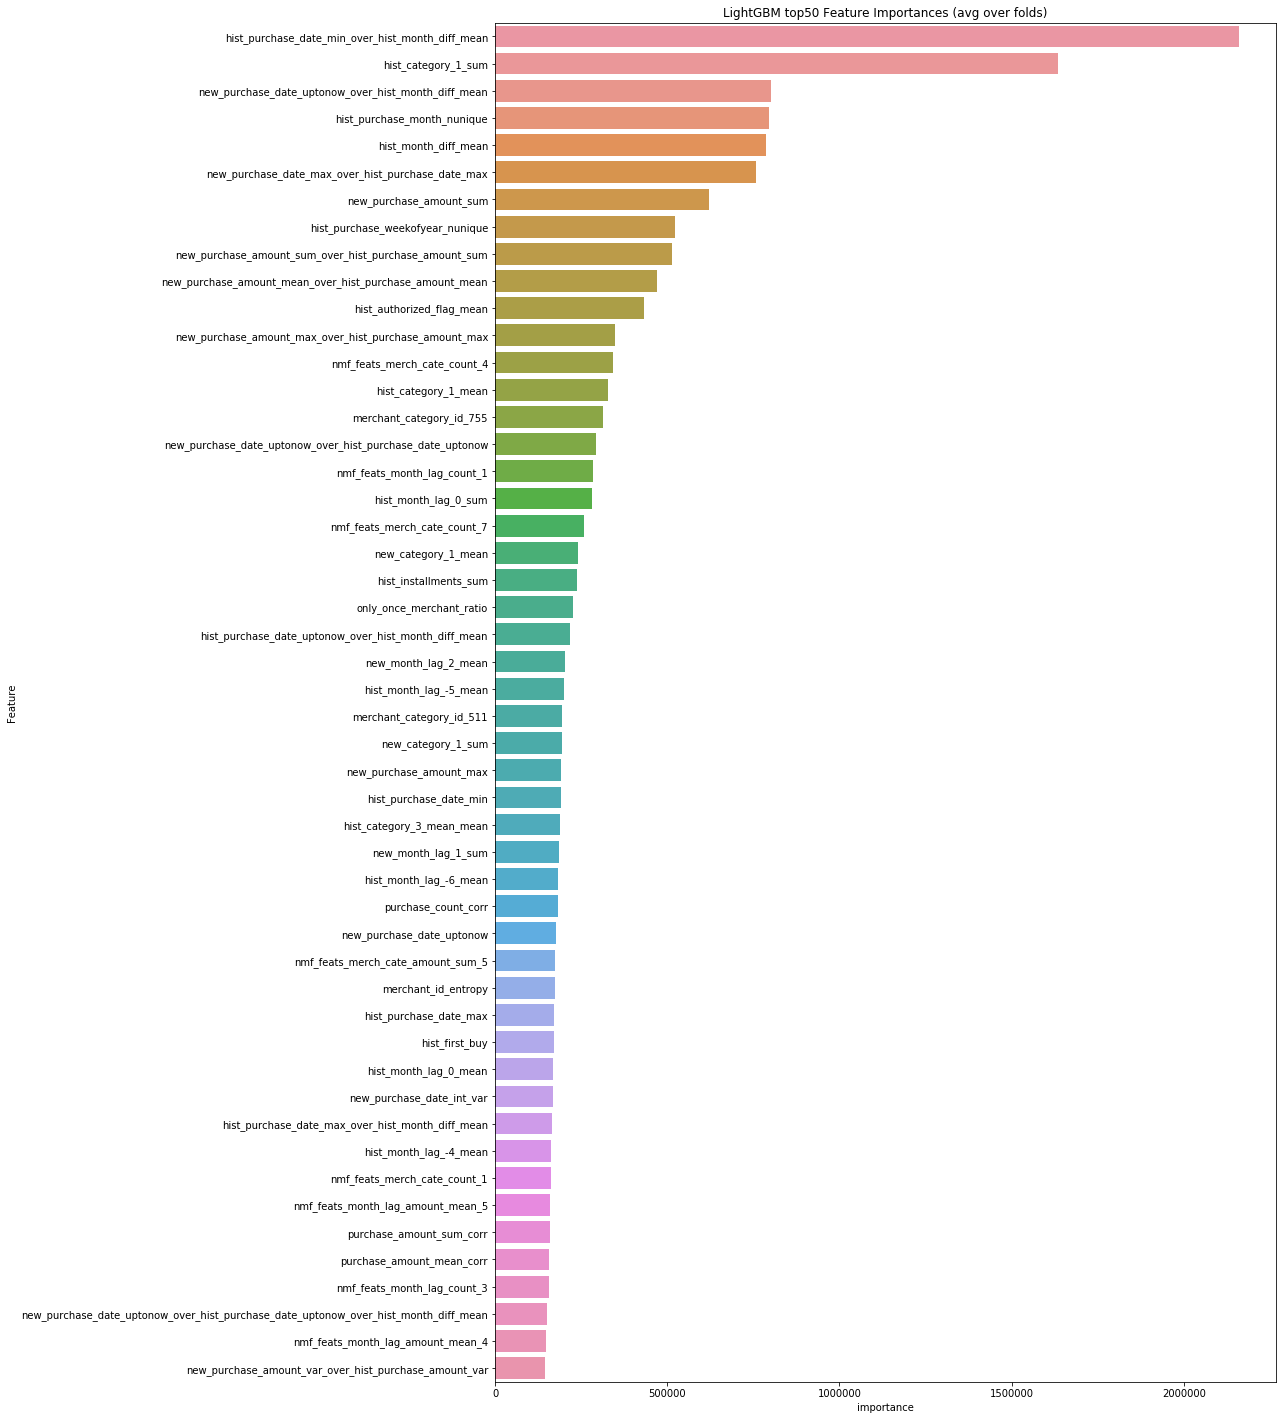

In [37]:
top_50_features = total_importance_df.sort_values(by='importance', ascending=False).head(50)
plt.figure(figsize=(14,25))
sns.barplot(x='importance', y='Feature', data=top_50_features)
plt.title('LightGBM top50 Feature Importances (avg over folds)')

### I did some feature selection as well as post processing after this but it only helped with improving Public LB and not Private LB. The seed averaged LightGBM scored 3.676 on Public LB and 3.609 on Private LB(104th).